In [1]:
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
import pandas as pd
import numpy as np



data_folder = "./data/"

#Get and load data
# pitch_14_17_file = "pitcher_2014_2017.csv"
bball_data_2_file = "Baseball Data-2.csv"

In [2]:
#moves 0 value of PlateLocHeight to middle of strikezone from the ground
def normalize_PlateLocHeight(PlateLocHeight):
    return ((PlateLocHeight * 12) - 30)/12

#preprocessing function used to calculate the plate location and isStrike classifier (this will be different than PitchCall (even in terms of BallCalled vs StrikeCalled))
#returns tuple: classification, isStrike
#classification: heart (strike) = 0, shadow (strike) = 1, shadow (ball) = 2, chase (ball) = 3, waste (ball) = 4
def PlateZone(PlateLocHeight, PlateLocSide):

    foot = 12

    #waste outside 84in to 6in, -20in to 20in horizontal, (strike zone * 200%)
    if ((PlateLocHeight > 7 or PlateLocHeight < 0.5) and (PlateLocSide < -(20/foot) or PlateLocSide > (20/foot))):
        return 4

    #heart inside 38in to 22in vertical, -6.7in to 6.7in horizontal, (strike zone size * 67%)
    if ((PlateLocHeight < (38/foot) and PlateLocHeight > (22/foot)) and (PlateLocSide > (-6.7/foot) and PlateLocSide < (6.7/foot))):
        return 0

    #strike zone inside 42in to 18in vertical, -10in to 10in horizontal
    if (PlateLocHeight < (42/foot) and PlateLocHeight > (18/foot) and (PlateLocSide > (-10/foot) and PlateLocSide < (10/foot))):
        return 1

    #shadow inside 46in to 14in vertical, -13.3in to 13.3in horizontal, (strike zone size * 133%)
    if (PlateLocHeight < (46/foot) and PlateLocHeight > (14/foot) and (PlateLocSide > (-13.3/foot) and PlateLocSide < (13.3/foot))):
        return 2

    #chase inside 84in to 6in, -20in to 20in horizontal, (strike zone * 200%)
    return 3

    #preprocessing function used to generate a single number that will be used to classify the ball/strike count before the current pitch 
    #returns int [0 - 11]
def PitchCount(balls, strikes):
    # Strikes: 0  1   2
    # Balls v|---------- 
    #       0| 0  1   2 
    #       1| 3  4   5
    #       2| 6  7   8
    #       3| 9  10  11
    if(balls == 0):
        if(strikes == 0):
            return 0
        if (strikes == 1):
            return 1
        return 2
    if(balls == 1):
        if(strikes == 0):
            return 3
        if (strikes == 1):
            return 4
        return 5
    if(balls == 2):
        if(strikes == 0):
            return 6
        if (strikes == 1):
            return 7
        return 8
    if(balls == 3):
        if(strikes == 0):
            return 9
        if (strikes == 1):
            return 10
        return 11

    #this preprocessing function generates the ground truth hitability of a pitch
    #these values will definitely need to be adjusted and should probably be hyperparameters
def GenerateGroundTruthLabels(pitchCall):
    if pitchCall == 'BallCalled':
        return -1
    if pitchCall == 'BallIntentional' or pitchCall == 'HitByPitch':
        return 0
    if pitchCall == 'StrikeSwinging' or pitchCall == 'StrikeCalled':
        return 1
    else:
        return 2


In [3]:
#import the columns we will need for training and preprocessing
bball_data = pd.read_csv(data_folder+bball_data_2_file, usecols=['Pitcher', 'PitcherThrows', 'Batter', 'BatterSide', 'PitchCall', 'KorBB', 'PlayResult', 'RunsScored', 'VertBreak', 'HorzBreak', 'ZoneSpeed', 'VertApprAngle', 'HorzApprAngle', 'ZoneTime', 'PlateLocHeight', 'PlateLocSide', 'Balls', 'Strikes', 'TaggedPitchType'])
#run preprocessing functions
#bball_data['Zone'] = bball_data.apply(lambda pitch : PlateZone(pitch['PlateLocHeight'], pitch['PlateLocSide']), axis=1) <- removed becasue we are using norm_PlateLocHeight and PlateLocSide
bball_data['BallStrikeNum'] = bball_data.apply(lambda pitch : PitchCount(pitch['Balls'], pitch['Strikes']), axis=1)
bball_data['GroundTruth'] = bball_data.apply(lambda pitch : GenerateGroundTruthLabels(pitch['PitchCall']), axis=1)

#normalize data
bball_data['norm_PlateLocHeight'] = bball_data.apply(lambda pitch : normalize_PlateLocHeight(pitch['PlateLocHeight']), axis=1)

#drop all features we no longer need (ones only used for preprocessing)
bball_data.drop(labels=['PitchCall', 'Pitcher', 'Batter', 'KorBB', 'PlayResult', 'Balls', 'Strikes', 'PitcherThrows','BatterSide','TaggedPitchType', 'PlateLocHeight'], axis=1, inplace=True)

#categorical_columns = ['Pitcher', 'Batter', 'KorBB', 'PlayResult', 'Zone', 'BallStrikeNum']
# ohe_bball_data = OneHotEncoder(sparse=False)
'''
for category in categorical_columns:
    bball_data[category] = bball_data[category].astype('category')
    # ohe_bball_data.fit_transform(bball_data[[category]])
'''

#Remove NaN valued rows
bball_data.dropna(inplace=True)
bball_data.reset_index(drop=True, inplace=True)

#print the labels of the features we will use to train our network
print(bball_data.keys())
#print(bball_data[bball_data.isna().any(axis=1)])
#print(ohe_bball_data.categories_)

#splitting data into training, validation, testing
total_samples = len(bball_data.index)
training_samples = math.floor(0.7*total_samples)
validation_samples = math.ceil(0.3*total_samples)
#testing_samples = math.ceil(0.2*total_samples)

sum = training_samples+validation_samples#+testing_samples

print("total samples:",total_samples,
        "\ntraining samples:",training_samples,
        "\nvalidation samples:",validation_samples,
        #"\ntesting samples:",testing_samples,
        #"\nsum of training, validation, and test samples:",sum)
        "\nsum of training, and validation:",sum)

#makes shuffled version of the data
indices = np.arange(total_samples)
np.random.shuffle(indices) #TODO get ground truth for data sets using these indices
shuffled_bball_data = bball_data.reindex(indices).reset_index(drop=True)
#gets the amount of random data points as determined by set proportion
training_data = shuffled_bball_data.iloc[0:training_samples]
validation_data = shuffled_bball_data.iloc[training_samples:training_samples+validation_samples]
#testing_data = shuffled_bball_data.iloc[training_samples+validation_samples:training_samples+validation_samples+testing_samples]

training_data

Index(['RunsScored', 'VertBreak', 'HorzBreak', 'PlateLocSide', 'ZoneSpeed',
       'VertApprAngle', 'HorzApprAngle', 'ZoneTime', 'BallStrikeNum',
       'GroundTruth', 'norm_PlateLocHeight'],
      dtype='object')
total samples: 1029515 
training samples: 720660 
validation samples: 308855 
sum of training, and validation: 1029515


,RunsScored,VertBreak,HorzBreak,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,BallStrikeNum,GroundTruth,norm_PlateLocHeight
0,0.0,-18.781413,9.438303,2.750108,85.381516,-2.903376,2.501270,0.408458,1.0,-1,1.849283
1,0.0,-40.292959,-15.026397,-0.503063,70.750052,-8.163105,0.167714,0.493862,11.0,2,-0.977185
2,0.0,-14.744605,-18.228035,0.095960,83.781722,-5.762808,1.720008,0.415395,10.0,1,-0.865885
3,0.0,-25.779732,11.582005,1.685738,79.387490,-4.877716,-0.717213,0.432743,0.0,-1,-0.327224
4,0.0,-27.833681,-2.982444,-0.408197,71.649954,-6.753992,0.561115,0.491098,5.0,2,-0.020440
...,...,...,...,...,...,...,...,...,...,...,...
720655,0.0,-32.730133,-3.833663,-0.977855,76.709266,-7.755618,-2.809749,0.456494,2.0,1,-0.794301
720656,0.0,-6.358340,5.033863,0.533631,85.976419,-4.707880,-1.030793,0.402035,11.0,2,0.164620
720657,0.0,-44.349750,-9.391150,-1.228990,74.018700,-7.617936,-4.156641,0.471131,5.0,1,-0.707800
720658,0.0,-52.825416,7.179800,0.087964,70.796801,-6.784192,3.921242,0.492825,5.0,1,1.371625


In [4]:
#scikit learn doesnt support categorical columns
#non_training_cols = [*categorical_columns, 'PitcherThrows','BatterSide','TaggedPitchType','GroundTruth']
non_training_cols = ['GroundTruth']
X = training_data.loc[:,~training_data.columns.isin(non_training_cols)]
y = training_data.loc[:,training_data.columns == 'GroundTruth']

vX = validation_data.loc[:,~validation_data.columns.isin(non_training_cols)]
vy = validation_data.loc[:,validation_data.columns == 'GroundTruth']

# decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=10000,max_depth=10)

#assigning different values for hyperparameters
#possible_min_leaf_samples = [1,1000,5000,10000,20000,30000,50000,100000,200000]
#possible_depths = [1,2,5,10,20,30,50,100,200]

possible_min_leaf_samples = list(range(1000, 20000, 2000))
possible_depths = list(range(1, 20, 5))

#validation (hyper-parameter tuning)
parameter_accuracy = []
for msl in possible_min_leaf_samples:
    for d in possible_depths:
        #train on training with this iteration of parameters
        decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=msl, max_depth=d)
        decision_tree = decision_tree.fit(X, y)
        #then check accuracy of validation data
        val_pred = decision_tree.predict(vX)
        score = metrics.accuracy_score(vy,val_pred)
        #put parameters and accuracy in matrix
        parameter_accuracy.append((msl,d,score,decision_tree.tree_.node_count))
        print(msl,d,score,decision_tree.tree_.node_count)

#select parameters with highest accuracy
parameter_accuracy.sort(key = lambda x:x[2])

best_parameters = parameter_accuracy[-1]
print(best_parameters)

#train new decision tree using best hyperparameters found above
decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=best_parameters[0], max_depth=best_parameters[1])
decision_tree = decision_tree.fit(X, y)
#test_input = testing_data.loc[:,~testing_data.columns.isin(non_training_cols)] <- replaced with vX
#test_ground_truth = testing_data.loc[:,testing_data.columns == 'GroundTruth'] <- replaced with vY

res_pred = decision_tree.predict(vX)
score = metrics.accuracy_score(vy,res_pred)
print(score*100)

1000 1 0.4381926794126694 3
(1000, 1, 0.4381926794126694, 3)
43.819267941266936


3


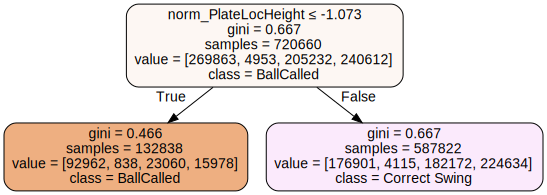

In [5]:
#use graphviz to make pdf and image of tree
import graphviz

# dot_data = tree.export_graphviz(decision_tree,out_file=None)
# graph = graphviz.Source(dot_data)
# graph.render("bball_basic_decision_tree")
print(decision_tree.tree_.node_count)

feature_labels = X.keys()
class_labels = ['BallCalled','BallIntentional/HitByPitch','StrikeSwinging/StrikeCalled',"Correct Swing"]

#tree with recognizable labels and color coded nodes corresponding to classes
dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names = feature_labels,
                                class_names = class_labels,
                                filled=True, rounded = True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("bball_basic_decision_tree_labeled")
graph 

In [6]:
#scikit learn doesnt support categorical columns
#non_training_cols = [*categorical_columns, 'PitcherThrows','BatterSide','TaggedPitchType','GroundTruth']
non_training_cols = ['GroundTruth']
X = training_data.loc[:,~training_data.columns.isin(non_training_cols)]
y = training_data.loc[:,training_data.columns == 'GroundTruth']

vX = validation_data.loc[:,~validation_data.columns.isin(non_training_cols)]
vy = validation_data.loc[:,validation_data.columns == 'GroundTruth']

#decision_forest = ensemble.RandomForestClassifier(n_estimators=50,max_depth=10,min_samples_leaf=10000)
#decision_forest.fit(X, y.values.ravel())

#assigning different values for hyperparameters
#possible_min_leaf_samples = [1,1000,5000,10000,20000,30000,50000,100000,200000]
#possible_depths = [1,2,5,10,20,30,50,100,200]
#possible_subtrees = [10, 25, 50, 75, 100]

possible_min_leaf_samples = list(range(1000, 10000, 2000))
possible_depths = list(range(1, 5, 1))
possible_subtrees = list(range(10, 110, 10))

#validation (hyper-parameter tuning)
parameter_accuracy = []
for msl in possible_min_leaf_samples:
    for d in possible_depths:
        for n_trees in possible_subtrees:
            #train on training with this iteration of parameters
            decision_forest = ensemble.RandomForestClassifier(n_estimators=n_trees, min_samples_leaf=msl, max_depth=d)
            decision_forest = decision_forest.fit(X, y.values.ravel())
            #then check accuracy of validation data
            val_pred = decision_forest.predict(vX)
            score = metrics.accuracy_score(vy,val_pred)
            #put parameters and accuracy in matrix
            parameter_accuracy.append((msl,d,n_trees,score))
            print(msl,d,n_trees,score)

#select parameters with highest accuracy
parameter_accuracy.sort(key = lambda x:x[3])

best_parameters = parameter_accuracy[-1]
print(best_parameters)

#train new decision tree using best hyperparameters found above
decision_forest = ensemble.RandomForestClassifier(min_samples_leaf=best_parameters[0], max_depth=best_parameters[1], n_estimators=best_parameters[2])
decision_forest = decision_forest.fit(X, y.values.ravel())
#test_input = testing_data.loc[:,~testing_data.columns.isin(non_training_cols)] <- replaced with vX
#test_ground_truth = testing_data.loc[:,testing_data.columns == 'GroundTruth'] <- replaced with vY

res_pred = decision_forest.predict(vX)
score = metrics.accuracy_score(vy,res_pred)
print(score*100)

1000 1 10 0.5116575739424649
1000 1 20 0.5152288290621813
1000 1 30 0.5165045085881724
1000 1 40 0.5171196839941072
1000 1 50 0.5191335740072203
1000 1 60 0.5145586116462417
1000 1 70 0.5185831539071732
1000 1 80 0.5212964012238753
1000 1 90 0.5237668161434977
1000 1 100 0.5227728221981188
1000 2 10 0.5969791649803305
1000 2 20 0.5821437244014182
1000 2 30 0.5773129785821826
1000 2 40 0.5773680205921873
1000 2 50 0.5915559081122209
1000 2 60 0.5775558109792621
1000 2 70 0.5919444399475482
1000 2 80 0.5963639895743957
1000 2 90 0.5970471580515129
1000 2 100 0.5739716047983682
1000 3 10 0.5758818863220605
1000 3 20 0.5935406582376843
1000 3 30 0.6097489113014197
1000 3 40 0.6160431270337213
1000 3 50 0.5982839843939712
1000 3 60 0.601233588577164
1000 3 70 0.6054782988781143
1000 3 80 0.6078062521247835
1000 3 90 0.6128312638616826
1000 3 100 0.5986401385763546
1000 4 10 0.6105583526250182
1000 4 20 0.6185005908921662
1000 4 30 0.6260122063751599
1000 4 40 0.61861391267747
1000 4 50 0.61